In [25]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# For data preprocess
import numpy as np
import pandas as pd
from pandas import DataFrame


# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['font.sans-serif']=['SimHei'] #pyplot中文显示


In [ ]:
use_gpu = torch.cuda.is_available()

In [50]:
#处理数据

time_stamp=20 #十分钟的数据，题目本来要求是利用一小时的数据，但如果用了1h(time_stamp=120),纬度就会不匹配，我不会改
train = pd.read_csv('D:/ML/HFenergy/风场1/x26/2018-07-30.csv')  #训练集
train=train.dropna()
#train=train[['变频器电网侧有功功率', '外界温度', '风向', '风速']]
train=train[['风速']]

valid= pd.read_csv('D:/ML/HFenergy/风场1/x26/2018-07-31.csv') 
valid=valid[['风速']]

x_train= []
y_train= []
for i in range(time_stamp, len(train)-21):
    x_train.append(train[i-time_stamp:i])
    y_train.append(train[i:i+20])
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train_ = x_train
y_train_ = y_train

x_train = x_train.reshape(-1, 1, 20) #将训练数据调整成pytorch中lstm算法的输入维度
y_train = y_train.reshape(-1, 1, 20)  #将目标值调整成pytorch中lstm算法的输出维度
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)-1):
    x_valid.append(valid[i - time_stamp:i])
    y_valid.append(valid[i:i+1])
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)


print(x_train.shape)
print(y_train.shape)


torch.Size([2839, 1, 20])
torch.Size([2839, 1, 20])


In [27]:
class RNN (nn.Module):
    def __init__(self):
        super(RNN,self).__init__() 
        self.lstm = nn.LSTM(20,8,2) 
        self.out = nn.Linear(8,20) 
        self.dropout = nn.Dropout(p=0.3)
    def forward(self,x):
        x1,_ = self.lstm(x)
        a,b,c = x1.shape
        out = self.out(x1.view(-1,c))#将lstm输出的三维数据x1调整成二维数据，最后的特征维度不能变
        out = self.dropout(out)
        out1 = out.view(a,b,-1) #把二维的out调整成三维数据，下一次循环使用
        return out1
rnn = RNN()

#参数寻优，计算损失函数
optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss()

In [6]:
for i in range(1000):
    var_x = Variable(x_train).type(torch.FloatTensor)
    var_y = Variable(y_train).type(torch.FloatTensor)
    out = rnn(var_x)
    loss = loss_func(out,var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1)%100==0:
        print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))

Epoch:100, Loss:0.00558
Epoch:200, Loss:0.00546
Epoch:300, Loss:0.00550


KeyboardInterrupt: 

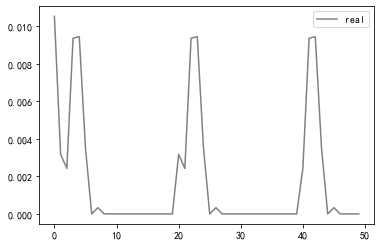

In [64]:
dataX1 = x_train_.reshape(-1,1,20)
dataX1=dataX1[:1]
dataX2 = torch.from_numpy(dataX1)
var_dataX = Variable(dataX2).type(torch.FloatTensor)

pred = rnn(var_dataX)

pred_test = pred.view(-1).data.numpy()  #转换成一维的ndarray数据，这是预测值

y_train2=x_train_.reshape(1,-1)[0]
y_train2=y_train2[1000:1050]

plt.plot(y_train2, 'grey', label='real')

#plt.plot(pred.view(-1).data.numpy(), 'b', label='prediction')

plt.legend(loc='best')
